# Connect 4 with CNNs
This Notebook implements a CNN that will be playing connect 4. It will be trained on a dataset of moves. Each sample in this set will contain a __board__ as a 6x7-pixel image, a __current player__ as scalar and a __target column__ as one hot vector. The model will then be trained to predict the target column depending on a board and a current player. Following sections are contained:

- **Building the Dataset**
- **Building the Model**
- **Training the Model**
- **Testing the Model**

## **Building the Datasets**
The samples are read from the file system and put into an Connect4Dataset. Each sample contains __board__, __current player__ and __target column__

Found 12756 samples


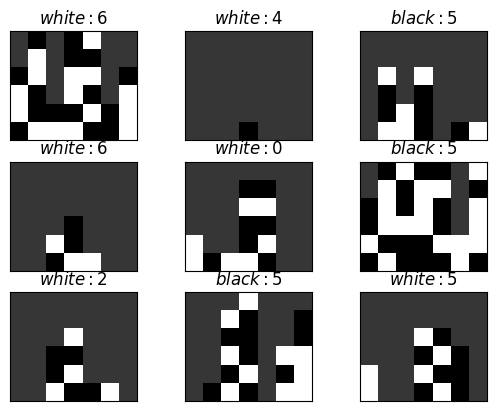

In [152]:
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

BATCH_SIZE = 10
NUM_EPOCHS = 30  # Number of training epochs

class C4Dataset(Dataset):
    """
    The C4Dataset is responsible for retrieving labeled data from the fs.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.player_folders = {'black': 0, 'white': 1}
        self.num_columns = 7

        self.data = self.load_data()

    def load_data(self):
        """
        Retrieves the data from the fs. Images are stored by their path to save memory.
        :return: the data 
        """
        data = []

        for player, player_idx in self.player_folders.items():
            player_dir = os.path.join(self.root_dir, player)

            for target_column in range(0, self.num_columns):
                column_dir = os.path.join(player_dir, str(target_column))
                image_filenames = os.listdir(column_dir)

                for image_filename in image_filenames:
                    image_path = os.path.join(column_dir, image_filename)
                    data.append((image_path, player_idx, torch.eye(self.num_columns)[target_column]))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Only here are images finally opened
        :param idx: idx of the sample
        :return: the image, player and target_column
        """
        image_path, player, target_column = self.data[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, player, target_column

def build_dataset(root_dir):
    # Define your transformations
    transform = transforms.Compose([
        transforms.Resize((6, 7)),    # Resize the images to a consistent size (e.g., 64x64)
        transforms.Grayscale(),       # Convert images to grayscale
        transforms.ToTensor(),        # Convert images to PyTorch tensors
    ])
    
    # Define your dataset
    dataset = C4Dataset(root_dir, transform=transform)
    print(f"Found {len(dataset)} samples")
    
    # split in test and training data
    train_size = int(0.8 * len(dataset))  # 80% for training
    test_size = int(len(dataset) - train_size)  # 20% for testing
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # visualize some samples
    for (board_batch, current_player_batch, column_batch) in train_loader:
        for i in range(0, min(10, len(board_batch))):
            plt.subplot(331 + i)
            plt.xticks([])
            plt.yticks([])
            plt.title(f"${['black', 'white'][current_player_batch[i]]}:${np.argmax(column_batch[i])}")
            arr = np.asarray(board_batch[i])
            arr = arr.reshape(6, 7)
            plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
            if i == 8:
                return train_loader, test_loader
        plt.show()
    
    return train_loader, test_loader

training, testing = build_dataset(root_dir = "c4set")

## **Building the Model**
As model, we use a CNN. It operates on the image of the board and stacks multiple convolutional layers together to enable Pattern recognition.
It is then followed by a seven layer dense neural network. The first vector of the dense neural network also receives the current player as second input. The produced output vector has length 7. It contains the estimated probabilities of putting the next token in the respective column being the best move.

In [153]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bot(torch.nn.Module):
    def __init__(self):
        super(Bot, self).__init__()

        self.conv1 = nn.Conv2d(1, 20, (2, 2))
        self.conv2 = nn.Conv2d(20, 30, (2, 2))
        self.conv3 = nn.Conv2d(30, 40, (2, 2))
        self.conv4 = nn.Conv2d(40, 50, (2, 2))
        self.fc1 = nn.Linear(3 * 2 * 50 + 1, 42)
        self.fc2 = nn.Linear(42 + 1, 42)
        self.fc3 = nn.Linear(42 + 1, 42)
        self.fc4 = nn.Linear(42 + 1, 42)
        self.fc7 = nn.Linear(42 + 1, 7)

    def forward(self, board, current_player):
        x = F.leaky_relu(self.conv1(board))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = x.view(-1, 3 * 2 * 50)  # Flatten with batch dimension
        player_info = current_player.unsqueeze(1).expand(-1, 1)  # Broadcast across batch
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc3(x))
        x = torch.cat((x, player_info), dim=1)
        x = F.leaky_relu(self.fc4(x))
        x = torch.cat((x, player_info), dim=1)
        x = self.fc7(x)
        return x

## **Training the Model**
As loss function we use CrossEntropy and as Optimizer SGD.

In [154]:
from torch.optim.lr_scheduler import ExponentialLR

def train(num_epochs):
    bot = Bot()
    binary_cross_entropy = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(bot.parameters(), lr=0.1)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        bot.train()  # Set the model to training mode

        for batch_idx, (board_batch, player_batch, move_batch) in enumerate(training):
            optimizer.zero_grad()
            outputs = bot(board_batch, player_batch)
            loss = binary_cross_entropy(outputs, move_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        print(f"epoch {epoch} --- loss: {running_loss / len(training)}")

    print("Training completed.")
    return bot


def get_accuracy(bot, dataset):
    bot.eval()
    total = 0
    correct = 0
    for board_sample, current_player, best_move in dataset:
        outputs = bot(board_sample, current_player)
        predicted_indices = torch.argmax(outputs, dim=1)
        labeled_indices = torch.argmax(best_move, dim=1)
        total += best_move.size(0)
        correct += (predicted_indices == labeled_indices).sum().item()
    
    bot.train()
    return 100 * correct / total

model = train(NUM_EPOCHS)

epoch 0 --- loss: 1.9404184778570313
epoch 1 --- loss: 1.9400328157230642
epoch 2 --- loss: 1.9395191955519704
epoch 3 --- loss: 1.9384748375264018
epoch 4 --- loss: 1.9383808986213602
epoch 5 --- loss: 1.9385678846385406
epoch 6 --- loss: 1.9382506669676853
epoch 7 --- loss: 1.9379214908887543
epoch 8 --- loss: 1.9377962984837935
epoch 9 --- loss: 1.9377707482318336
epoch 10 --- loss: 1.9370396008804427
epoch 11 --- loss: 1.9377319690179404
epoch 12 --- loss: 1.9372273241037485
epoch 13 --- loss: 1.9371390628767995
epoch 14 --- loss: 1.9369234576398082
epoch 15 --- loss: 1.9368979049359434
epoch 16 --- loss: 1.9368917852143932
epoch 17 --- loss: 1.9369797358666998
epoch 18 --- loss: 1.9367459074874116
epoch 19 --- loss: 1.9366750100684096
epoch 20 --- loss: 1.936574156090515
epoch 21 --- loss: 1.9365706700652867
epoch 22 --- loss: 1.9365894446527105
epoch 23 --- loss: 1.936481871520854
epoch 24 --- loss: 1.936412590841355
epoch 25 --- loss: 1.9363917436935993
epoch 26 --- loss: 1.9364

## **Testing the Model**
We give the model the test subset and calculate the accuracy.


In [155]:
test_acc = get_accuracy(model, testing)
print(f"Accuracy on the test set: {test_acc:.2f}%")

training_acc = get_accuracy(model, training)
print(f"Accuracy on the training set: {training_acc:.2f}%")

Accuracy on the test set: 17.67%
Accuracy on the training set: 18.55%
